<a href="https://colab.research.google.com/github/hojoooon/PDM16/blob/main/py-tensorflow/pdm16_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Transfer learning(전이 학습) 이란?

##### - 전이학습이란 아주 큰 데이터셋에 훈련된 모델의 가중치를 가지고 와서 해결하고자 하는 과제에 맞게 재보정해서 사용하는 것을 의미

##### -> 비교적 적은 수의 데이터를 가지고도 딥러닝 모델 훈련 가능

### TL Result

##### 검증 데이터셋에 대한 최대 정확도는 약 0.89
##### test데이터의 개수를 더 늘린다면 더 높은 정확도가 나올 것으로 기대함

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
# import cv2
print(tf.__version__)

2.7.0


In [ ]:
tf.keras.backend.clear_session()  # For memory

# GPU check
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("#### ", len(gpus), "Physical GPUs,",
                 len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('#### No CUDA supported GPU in this computer.')

####  1 Physical GPUs, 1 Logical GPUs


#### Model Creation

In [ ]:
TL_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
len(TL_base.layers)

154

In [ ]:
TL_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
TL_base.layers[-1].get_config() # (7, 7, 1280)

{'dtype': 'float32',
 'max_value': array(6., dtype=float32),
 'name': 'out_relu',
 'negative_slope': array(0., dtype=float32),
 'threshold': array(0., dtype=float32),
 'trainable': True}

In [ ]:
(x_train0, y_train0), (x_test0, y_test0) = cifar10.load_data()

# x_train=x_train/255.0
# x_test=x_test/255.0
print(y_train0.shape)
x = x_train0.astype('float32')
x_test1 = x_test0.astype('float32')

x = preprocess_input(x)
x_test1 = preprocess_input(x_test1)

x_train, x_test, y_train, y_test = train_test_split(x,y_train0, test_size = 0.1, random_state = 42)

# No one-hot encoding
# y_train = np_utils.to_categorical(y_train, 10)
# y_test = np_utils.to_categorical(y_test, 10)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(50000, 1)
(45000, 32, 32, 3)
(45000, 1)
(5000, 32, 32, 3)


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_train.shape,y_test.shape

((45000, 10), (5000, 10))

In [ ]:
x_train.shape,len(x_train),x_train[4].shape

((45000, 32, 32, 3), 45000, (32, 32, 3))

## Sequential model
- TL base: resnet

In [ ]:
# Set TL_base trainable or not.
TL_base.trainable = False  # Use the representative features pretrained by resnet.

In [ ]:
model = models.Sequential()
model.add(keras.Input(shape=(32,32,3)))
model.add(layers.UpSampling2D((7,7)))  # 32*7 = 224
model.add(TL_base)
model.add(layers.GlobalAveragePooling2D()) # (7,7,2048) => (2048,)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

# model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy
                metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                          

### Data augmentation and Network Architecture

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(x_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(50, 32, 32, 3) [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

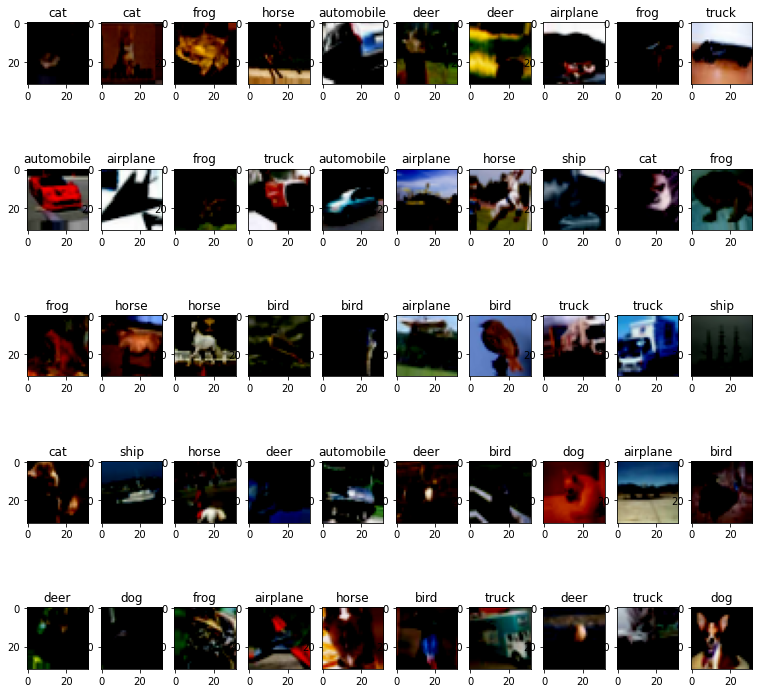

In [ ]:
class_names =  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

BATCH_SIZE = 50
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=BATCH_SIZE):
    print(X_batch.shape, y_batch)
    # create a grid of 5x10 images
    plt.figure(figsize=(13,13))
    for i in range(BATCH_SIZE):
        plt.subplot(5,10,i+1)
        plt.imshow(X_batch[i]) #, cmap=plt.get_cmap('gray'))
        plt.title(class_names[np.argmax(y_batch[i])])
        # show the plot
    plt.show()
    break

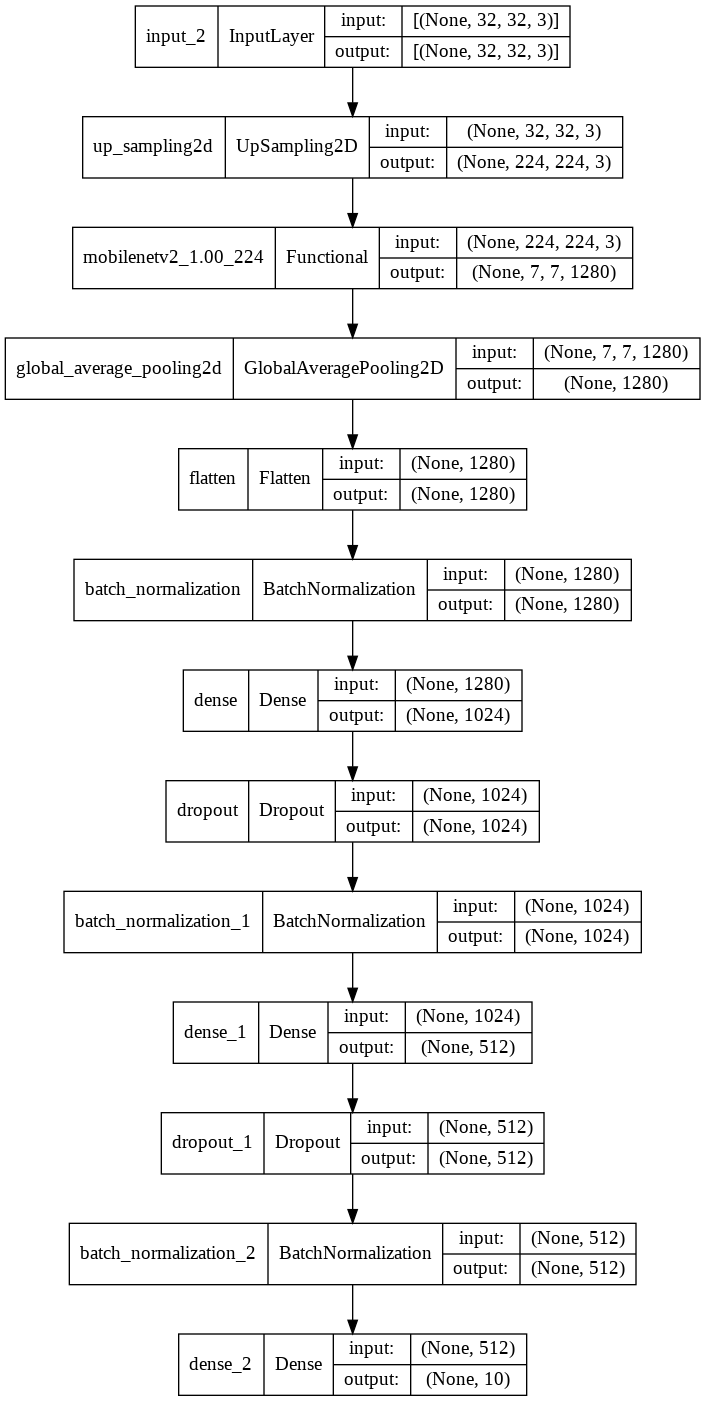

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_S.png')

### Fit model before Fine Tuning, Find the best model after fit Fine Tuned model

In [ ]:
tf.keras.backend.clear_session()  # For memory
TL_base.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(TL_base.layers))

Number of layers in the base model:  154


In [ ]:
fine_tune_at = 107  # 81, 107 for mobilenetV2

# Freeze all the layers before the `fine_tune_at` layer
for layer in TL_base.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(optimizer='SGD', 
                loss='categorical_crossentropy',  # sparse_categorical_crossentropy
                metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                          

In [ ]:
from tensorflow.keras import layers, models, callbacks

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10_10per_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

In [ ]:
print(x_train.shape, y_train.shape)

(45000, 32, 32, 3) (45000, 10)


In [ ]:
print(x_test.shape, y_test.shape)

(5000, 32, 32, 3) (5000, 10)


In [ ]:
%%time
history = model.fit(x_train, y_train, 
                    epochs=100, batch_size=50, 
                    validation_data=(x_test, y_test),
                    callbacks=[mc_callback,es_callback])

Epoch 1/100
900/900 [==============================] - ETA: 0s - loss: 0.9216 - accuracy: 0.6978

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


900/900 [==============================] - 184s 189ms/step - loss: 0.9216 - accuracy: 0.6978 - val_loss: 1.3080 - val_accuracy: 0.6174
Epoch 2/100
900/900 [==============================] - 160s 177ms/step - loss: 0.4623 - accuracy: 0.8465 - val_loss: 0.6320 - val_accuracy: 0.8012
Epoch 3/100
900/900 [==============================] - 169s 187ms/step - loss: 0.3283 - accuracy: 0.8924 - val_loss: 0.4708 - val_accuracy: 0.8470
Epoch 4/100
900/900 [==============================] - 159s 177ms/step - loss: 0.2404 - accuracy: 0.9196 - val_loss: 0.3813 - val_accuracy: 0.8710
Epoch 5/100
900/900 [==============================] - 159s 177ms/step - loss: 0.1738 - accuracy: 0.9423 - val_loss: 0.4264 - val_accuracy: 0.8726
Epoch 6/100
900/900 [==============================] - 168s 186ms/step - loss: 0.1301 - accuracy: 0.9571 - val_loss: 0.4274 - val_accuracy: 0.8662
Epoch 7/100
900/900 [==============================] - 168s 187ms/step - loss: 0.0998 - accuracy: 0.9667 - val_loss: 0.5943 - val_

In [ ]:
model.evaluate(x_test, y_test, batch_size=50)

100/100 [==============================] - 12s 117ms/step - loss: 0.5799 - accuracy: 0.8630


[0.5798982381820679, 0.8629999756813049]

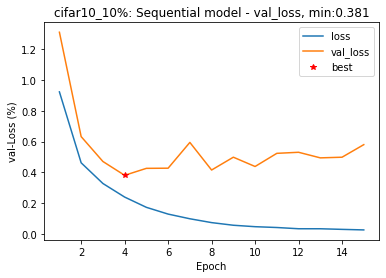

In [ ]:
epochs = range(1, len(history.history['loss']) + 1)

loss_list = history.history['loss'] #[100 * i for i in history.history['loss']]
vloss_list = history.history['val_loss'] #[100 * i for i in history.history['val_loss']]

plt.plot(epochs,loss_list)  
plt.plot(epochs,vloss_list)

plt.plot(np.argmin(np.array(vloss_list))+1,vloss_list[np.argmin(np.array(vloss_list))], 'r*')
plt.title('cifar10_10%: Sequential model - val_loss, min:' + str(np.round(vloss_list[np.argmin(np.array(vloss_list))],3)))
plt.ylabel('val-Loss (%)')
plt.xlabel('Epoch')
plt.legend(['loss','val_loss','best'], loc='best')
plt.show()

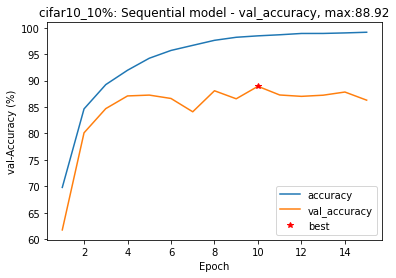

In [ ]:
epochs = range(1, len(history.history['accuracy']) + 1)

acc_list = [100 * i for i in history.history['accuracy']]
vacc_list = [100 * i for i in history.history['val_accuracy']]

plt.plot(epochs,acc_list)  
plt.plot(epochs,vacc_list)

plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*')
plt.title('cifar10_10%: Sequential model - val_accuracy, max:' + str(np.round(vacc_list[np.argmax(np.array(vacc_list))],3)))
plt.ylabel('val-Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy','best'], loc='best')
plt.show()

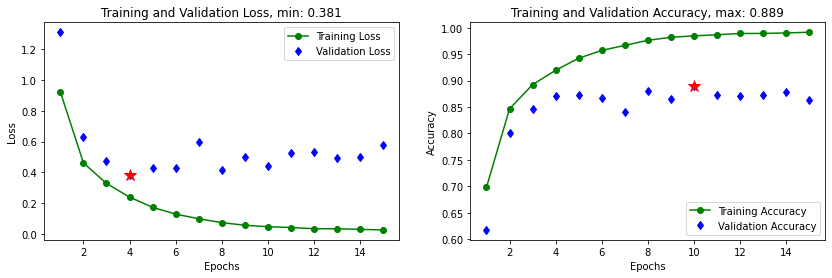

In [ ]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],3)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],3)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
tf.keras.backend.clear_session()  # For memory
TL_base.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(TL_base.layers))

Number of layers in the base model:  154


In [ ]:
INITIAL_EPOCHS = len(loss)
FINE_TUNE_EPOCHS = 100
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10_10per_tuned_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

In [ ]:
%%time
history_fine = model.fit(x_train, y_train, 
                    epochs=TOTAL_EPOCHS, 
                    initial_epoch=INITIAL_EPOCHS,
                    batch_size=50, 
                    validation_data=(x_test, y_test),
                    callbacks=[mc_callback,es_callback])

Epoch 16/115
900/900 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9924

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


900/900 [==============================] - 169s 187ms/step - loss: 0.0238 - accuracy: 0.9924 - val_loss: 0.4791 - val_accuracy: 0.8878
Epoch 17/115
900/900 [==============================] - 158s 176ms/step - loss: 0.0199 - accuracy: 0.9940 - val_loss: 0.5107 - val_accuracy: 0.8854
Epoch 18/115
900/900 [==============================] - 168s 186ms/step - loss: 0.0193 - accuracy: 0.9941 - val_loss: 0.5244 - val_accuracy: 0.8798
Epoch 19/115
900/900 [==============================] - 158s 176ms/step - loss: 0.0197 - accuracy: 0.9938 - val_loss: 0.4828 - val_accuracy: 0.8864
Epoch 20/115
900/900 [==============================] - 168s 186ms/step - loss: 0.0178 - accuracy: 0.9943 - val_loss: 0.5455 - val_accuracy: 0.8834
Epoch 21/115
900/900 [==============================] - 168s 187ms/step - loss: 0.0161 - accuracy: 0.9951 - val_loss: 0.5219 - val_accuracy: 0.8894
Epoch 22/115
900/900 [==============================] - 168s 186ms/step - loss: 0.0149 - accuracy: 0.9955 - val_loss: 0.5157 

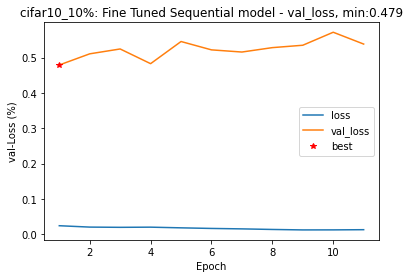

In [ ]:
epochs = range(1, len(history_fine.history['loss']) + 1)

loss_list = history_fine.history['loss'] #[100 * i for i in history.history['loss']]
vloss_list = history_fine.history['val_loss'] #[100 * i for i in history.history['val_loss']]

plt.plot(epochs,loss_list)  
plt.plot(epochs,vloss_list)

plt.plot(np.argmin(np.array(vloss_list))+1,vloss_list[np.argmin(np.array(vloss_list))], 'r*')
plt.title('cifar10_10%: Fine Tuned Sequential model - val_loss, min:' + str(np.round(vloss_list[np.argmin(np.array(vloss_list))],3)))
plt.ylabel('val-Loss (%)')
plt.xlabel('Epoch')
plt.legend(['loss','val_loss','best'], loc='best')
plt.show()

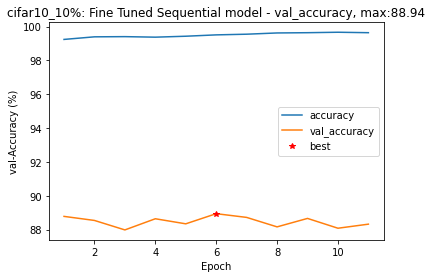

In [ ]:
epochs = range(1, len(history_fine.history['accuracy']) + 1)

acc_list = [100 * i for i in history_fine.history['accuracy']]
vacc_list = [100 * i for i in history_fine.history['val_accuracy']]

plt.plot(epochs,acc_list)  
plt.plot(epochs,vacc_list)

plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*')
plt.title('cifar10_10%: Fine Tuned Sequential model - val_accuracy, max:' + str(np.round(vacc_list[np.argmax(np.array(vacc_list))],3)))
plt.ylabel('val-Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy','best'], loc='best')
plt.show()

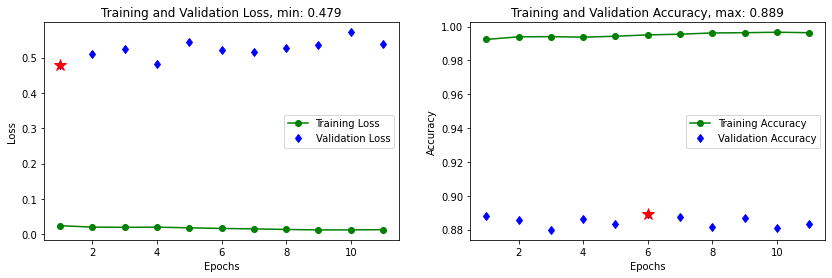

In [ ]:
history_dict_tuned = history_fine.history
loss = history_dict_tuned['loss']
val_loss = history_dict_tuned['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],3)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict_tuned['accuracy']
val_acc = history_dict_tuned['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],3)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Confusion matrix

In [ ]:
from keras.models import load_model

model_best = load_model('./model/cifar10_10per_tuned_best_weights.024-0.8934.hdf5')
model_best.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model_best.predict(x_test)
predictions0 = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_test, predictions0)

In [ ]:
import seaborn as sns

plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix', fontsize=20)
plt.show()